# GRAPH - Graph Mining - CS - PARIS - SACLAY (2024-2025)
## Professor: Nacéra Seghouani

# Import Libraries

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community as community_louvain  # Louvain algorithm
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
import itertools
from collections import defaultdict
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, fcluster
from node2vec import Node2Vec
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import procrustes
import matplotlib.pyplot as plt

# Import Graph

In [3]:
def create_graph_from_tsv(filepath: str, num_nodes_to_consider: int) -> nx.Graph:
    """
    Reads a TSV file with edge list and creates a homogeneous graph.
    Only nodes with assigned integer IDs <= num_nodes_to_consider are included.
    
    The TSV file is expected to have two columns (source and target) separated by tab
    with no header. This version uses separate mappings for source (disease) and target (gene).
    
    Args:
        filepath: The path to the TSV file.
        num_nodes_to_consider: The maximum node id value to include.
        
    Returns:
        G: A NetworkX graph with edges only if both endpoints are <= num_nodes_to_consider.
    """
    G = nx.Graph()
    num_d = defaultdict(int)  # mapping for source (disease) nodes
    num_g = defaultdict(int)  # mapping for target (gene) nodes
    first_row = True
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            # If file has a header, skip the first line
            if first_row:
                first_row = False
                continue
            source, target = parts[0], parts[1]
            # Update disease mapping
            if source not in num_d:
                num_d[source] = len(num_d) + 1  # start IDs at 1
            # Update gene mapping
            if target not in num_g:
                num_g[target] = len(num_g) + 1
            source_id = num_d[source]
            target_id = num_g[target]
            if source_id <= num_nodes_to_consider and target_id <= num_nodes_to_consider:
                G.add_edge(source_id, target_id)
    return G


In [4]:
def create_hetero_graph_from_tsv(filepath: str, num_nodes_to_consider: int) -> nx.Graph:
    """
    Reads a TSV file with edge list and creates a heterogeneous graph using NetworkX, considering only nodes up to a specified number.

    The TSV file is expected to have two columns with no header, where each row represents an edge between two nodes of different categories.

    Args:
        filepath: The path to the TSV file containing the edge list.
        num_nodes_to_consider: The maximum node number to include in the graph.

    Returns:
        A NetworkX graph object created from the edge list in the TSV file, considering only the specified nodes, with node categories.
    """
    # Create a new graph
    G = nx.Graph()

    num_d = defaultdict(int)  # For diseases
    num_g = defaultdict(int)  # For genes
    first_row = True

    # Open the TSV file and read lines
    with open(filepath, 'r') as file:
        for line in file:
            # Skip header
            if first_row:
                first_row = False
                continue
            source, _, target = line.strip().split('\t')

            disease_id, disease_name, gene_id = line.strip().split('\t')
            # Update disease and gene mappings
            if source not in num_d:
                num_d[source] = 2*len(num_d) + 1  # Avoid 0 index
            if target not in num_g:
                num_g[target] = 2*len(num_g) + 2  # Avoid 0 index

            # Map to integers
            source_id, target_id = num_d[source], num_g[target]

            # Check if both nodes are within the specified limit
            if source_id <= num_nodes_to_consider and target_id <= num_nodes_to_consider:
              # Add nodes with their category if they haven't been added yet
              if source_id not in G:
                  G.add_node(source_id, category='disease', name=disease_name)
              if target_id not in G:
                  G.add_node(target_id, category='gene', name=gene_id)

              # Add edge between source and target
              G.add_edge(source_id, target_id)

    return G, num_d, num_g

In [5]:
def plot_hetero_graph(G: nx.Graph) -> None:
    """
    Plots a heterogeneous graph with nodes colored by category.
    
    Disease nodes (category='disease') are colored blue and gene nodes red.
    """
    color_map = ['blue' if G.nodes[node].get('category') == 'disease' else 'red' for node in G.nodes()]
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=False, node_color=color_map, edge_color='gray', node_size=30)
    plt.title("Heterogeneous Disease–Gene Graph (max nodes)")
    plt.show()


In [6]:
G, _, _= create_hetero_graph_from_tsv('data_disease\DG-AssocMiner_miner-disease-gene.tsv', num_nodes_to_consider=267328736821372)
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph loaded with 7813 nodes and 21357 edges.


In [7]:
G_200_nodes, num_d, num_g = create_hetero_graph_from_tsv('data_disease\DG-AssocMiner_miner-disease-gene.tsv', num_nodes_to_consider=200)

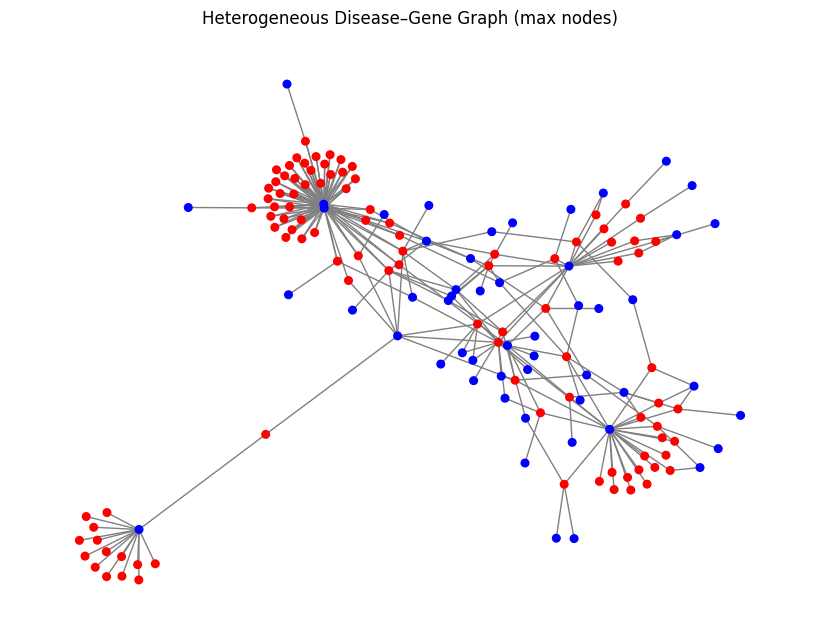

In [8]:
plot_hetero_graph(G_200_nodes)

# Centralities

In [47]:
import time


def compute_centralities(G: nx.Graph) -> dict:
    """
    Computes centrality measures for graph G.
    Returns a dictionary with keys as centrality measure names and values as node-to-score dictionaries.
    """
    centralities = {}
    t0 = time.time()
    centralities['degree'] = nx.degree_centrality(G)
    print("Degre centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['avg_neighbor_degree'] = nx.average_neighbor_degree(G)
    print("Neighborhood connectivity computation duration: ", str(time.time() - t0))

    t0 = time.time()
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print("Warning: Eigenvector centrality did not converge.")
        centralities['eigenvector'] = None
    print("Eigenvector centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    try:
        centralities['katz'] = nx.katz_centrality_numpy(G)
    except Exception as e:
        print("Katz centrality error:", e)
        centralities['katz'] = None
    print("Katz centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['pagerank'] = nx.pagerank(G)
    print("Pagerank centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['clustering'] = nx.clustering(G)
    print("Clustering centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['closeness'] = nx.closeness_centrality(G)
    print("Closeness centrality computation duration: ", str(time.time() - t0))

    # Betweenness takes too much time
    # t0 = time.time()
    # centralities['betweenness'] = nx.betweenness_centrality(G)
    # print("Betweenness centrality computation duration: ", str(time.time() - t0))

    return centralities


In [ ]:
def plot_centrality_histograms(centralities: dict) -> None:
    """
    Creates histograms for each available centrality measure.
    """
    num_measures = sum(1 for key, val in centralities.items() if val is not None)
    plt.figure(figsize=(15, 12))
    plot_index = 1
    for key, cent in centralities.items():
        if cent is None:
            continue
        values = list(cent.values())
        plt.subplot(3, 3, plot_index)
        plt.hist(values, bins=20, edgecolor='black')
        plt.title(f"{key.capitalize()} Centrality")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plot_index += 1
    plt.tight_layout()
    plt.show()


In [67]:
def print_top5_by_category(cent_dict: dict, G: nx.Graph, measure_name: str) -> None:
    """
    Prints the top 5 disease nodes and top 5 gene nodes for a given centrality measure.
    The name and ID (from the node attributes) and the score are printed.
    """
    disease_vals = {n: val for n, val in cent_dict.items() if G.nodes[n].get('category') == 'disease'}
    gene_vals = {n: val for n, val in cent_dict.items() if G.nodes[n].get('category') == 'gene'}
    top5_diseases = sorted(disease_vals.items(), key=lambda x: x[1], reverse=True)[:5]
    top5_genes = sorted(gene_vals.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\nCentrality Measure: {measure_name.capitalize()}")
    print("  Top 5 Disease Nodes:")
    for node, score in top5_diseases:
        name = G.nodes[node].get('name', f"Node {node}")
        print(f"    {name} (ID: {node}) - {score:.4f}")
    print("  Top 5 Gene Nodes:")
    for node, score in top5_genes:
        name = G.nodes[node].get('name', f"Node {node}")
        print(f"    {name} (ID: {node}) - {score:.4f}")


In [66]:
def plot_graph_with_node_size(G: nx.Graph, cent: dict, title: str = "",
                              scale: float = 5000, highlight_size: float = 300) -> None:
    """
    Plots the graph with node sizes proportional to a given centrality measure.
    Additionally, nodes with the maximum centrality score are highlighted in yellow
    and drawn with a fixed size specified by highlight_size.
    
    Args:
      G: The graph.
      cent: Dictionary of centrality scores per node.
      title: Title for the plot.
      scale: Scaling factor applied to node size.
      highlight_size: The fixed node size for nodes with the highest centrality.
    """
    pos = nx.spring_layout(G, seed=42)
    max_val = max(cent.values())
    sizes = []
    colors = []
    for node in G.nodes():
        # If a node's centrality equals the maximum (within a tolerance), highlight it
        if abs(cent[node] - max_val) < 1e-6:
            sizes.append(highlight_size)
            colors.append('yellow')
        else:
            sizes.append(cent[node] * scale)
            if G.nodes[node].get('category') == 'disease':
                colors.append('blue')
            else:
                colors.append('red')
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_size=sizes, node_color=colors, edge_color='gray', with_labels=False)
    plt.title(title)
    plt.show()


In [65]:
centralities_full = compute_centralities(G)

Degre centrality computation duration:  0.0
Neighborhood connectivity computation duration:  0.04207777976989746
Eigenvector centrality computation duration:  2.1932485103607178
Katz centrality computation duration:  9.358613967895508
Pagerank centrality computation duration:  0.1744062900543213
Clustering centrality computation duration:  0.22133183479309082
Closeness centrality computation duration:  46.7996609210968


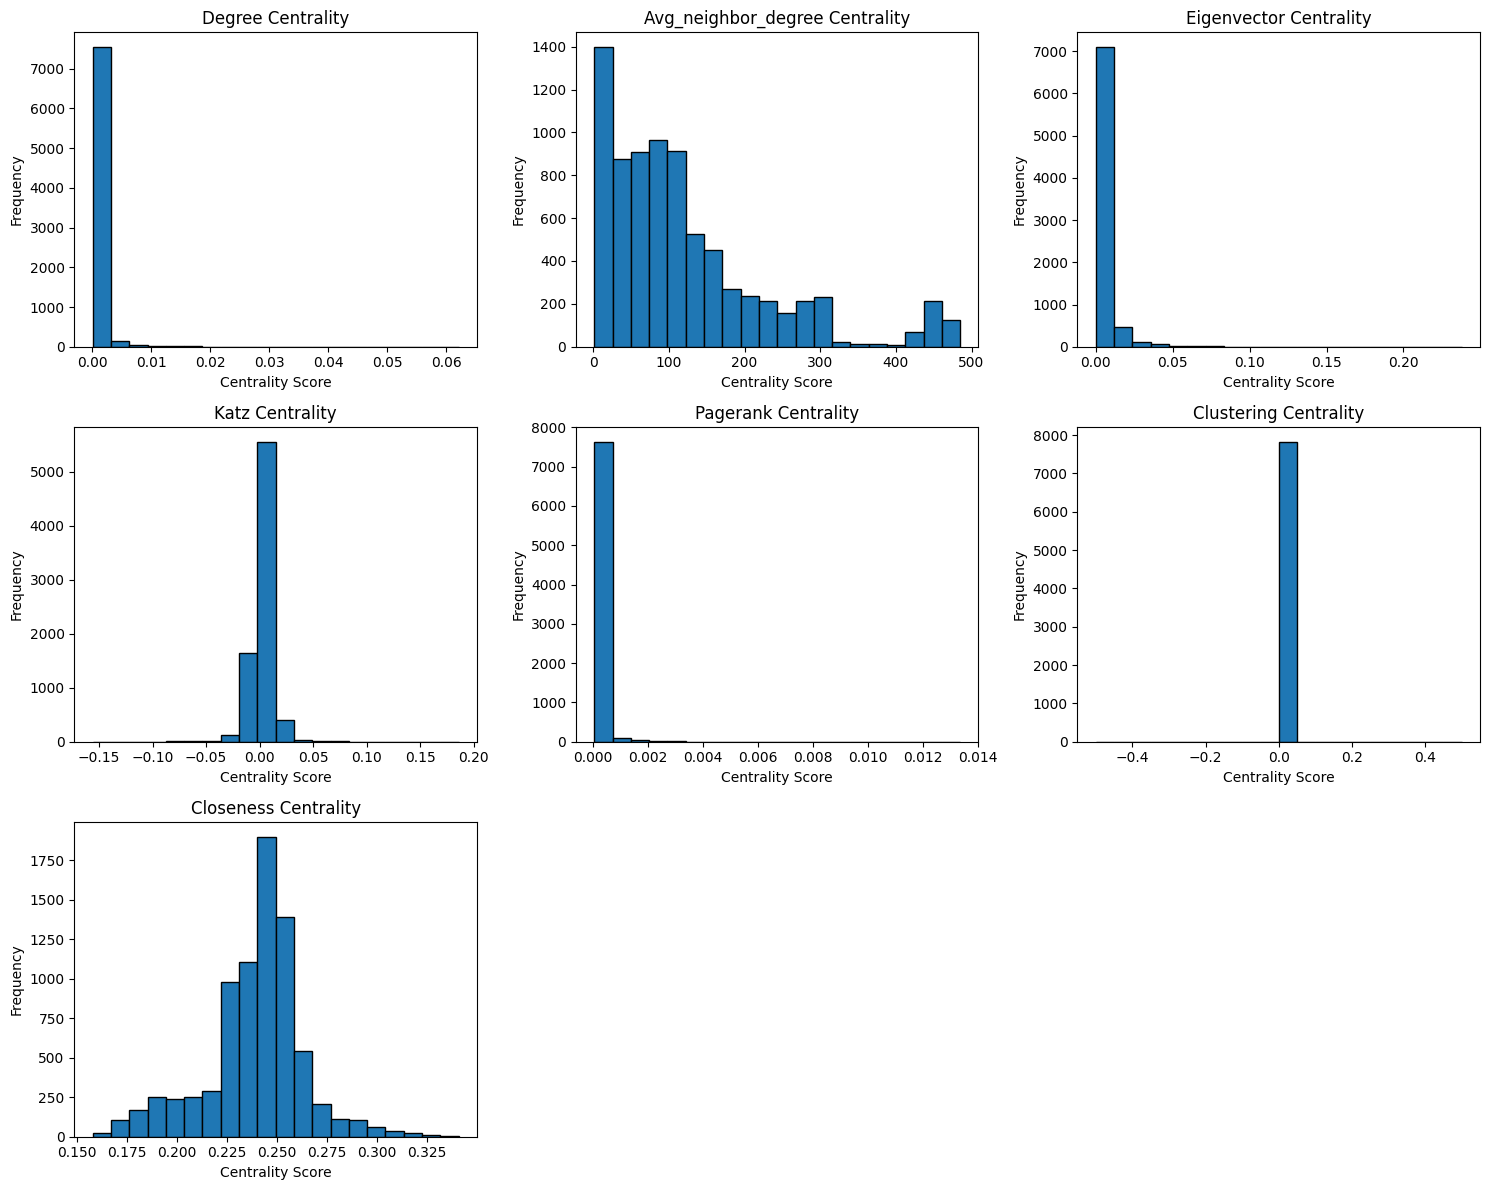

In [49]:
plot_centrality_histograms(centralities_full)

Below is an expanded, cohesive discussion of the main centrality measures and what they reveal in this bipartite disease–gene graph. The explanations highlight why certain diseases and genes rise to the top for each metric and how to interpret these findings biologically


1) Degree Centrality
- Degree centrality counts how many neighbors a given node has. For diseases, a high degree means many different genes are associated with that disease. In our top results, this naturally brings up diseases like mammary (breast) cancer and obesity; both are known to be highly polygenic and extensively studied, so many genes have been identified as relevant. Biologically, a high-degree disease often indicates it is widespread, well-researched, and linked to numerous molecular pathways.


2) Neighborhood Connectivity
- Because our graph has only disease–gene edges (no disease–disease or gene–gene links), a node’s neighborhood connectivity highlights how many other diseases its neighboring genes are connected to. Put another way, a disease with high neighborhood connectivity has genes that also appear in many other diseases, suggesting strong comorbidities or shared genetic bases. For instance, a disease such as hypoglycemia or alcoholic liver cirrhosis may show high neighborhood connectivity if the genes involved also play roles in many other conditions. Clinically, that means patients with these diseases can be prone to additional complications, reflecting the large overlap of implicated genes.

3) PageRank Centrality
- It effectively flattens out, offering little added biological interpretation beyond simpler measures

4) Clustering Coefficient
- We observe a clustering coefficient of 0.0 throughout, which follows from the same bipartite constraint: there are no disease–disease or gene–gene edges to close any “triangles.” Triangles (three nodes all mutually connected) cannot form unless there is at least one disease–disease or gene–gene link. Hence no local clustering occurs.

5) Eigenvector & Katz Centrality
- These two measures go beyond direct counts of neighbors by considering each neighbor’s own influence. Eigenvector centrality is high when a node is connected to other nodes that also have high centralities; Katz centrality is conceptually similar but adds a baseline “influence” so that nodes with few connections can still gain rank if they link to very influential neighbors. These are all common or highly studied cancers. Because they connect to numerous genes that themselves have multiple other disease associations, the diseases’ “influence” keeps rising in the eigenvector calculation. These genes are often “hub” genes, participating in many disease pathways. High eigenvector centrality means they connect to diseases that themselves are strongly connected and widely investigated.


6) Closeness Centrality
- Closeness centrality measures how close a node is to all others, based on the inverse of average shortest path distances. In our disease–gene graph, centrally located nodes, like the cancers, have high closeness because they connect to many genes and reach others quickly. Biologically, cancers involve many overlapping pathways and are well-studied, making them hubs in the network. This widespread connectivity pulls them toward the center. In contrast, rare diseases with fewer gene links sit on the periphery, showing lower closeness values.



In [68]:
for measure, cent in centralities_full.items():
    if cent is None:
        continue
    print_top5_by_category(cent, G, measure)


Centrality Measure: Degree
  Top 5 Disease Nodes:
    "Prostatic Neoplasms" (ID: 239) - 0.0621
    "IGA Glomerulonephritis" (ID: 945) - 0.0576
    "Mammary Neoplasms" (ID: 561) - 0.0554
    "Obesity" (ID: 923) - 0.0381
    "Peripheral Neuropathy" (ID: 369) - 0.0375
  Top 5 Gene Nodes:
    7124 (ID: 272) - 0.0147
    6648 (ID: 118) - 0.0123
    5743 (ID: 392) - 0.0106
    3569 (ID: 208) - 0.0101
    7157 (ID: 276) - 0.0087

Centrality Measure: Avg_neighbor_degree
  Top 5 Disease Nodes:
    "Hypoglycemia" (ID: 621) - 40.5000
    "Leishmaniasis, Visceral" (ID: 249) - 37.4286
    "Cachexia" (ID: 841) - 36.3000
    "Papilloma" (ID: 297) - 36.2727
    "Liver Cirrhosis, Alcoholic" (ID: 151) - 36.0000
  Top 5 Gene Nodes:
    100188789 (ID: 5152) - 485.0000
    10040 (ID: 5154) - 485.0000
    10158 (ID: 5156) - 485.0000
    10263 (ID: 5160) - 485.0000
    10333 (ID: 5162) - 485.0000

Centrality Measure: Eigenvector
  Top 5 Disease Nodes:
    "Mammary Neoplasms" (ID: 561) - 0.2378
    "Prostati

In [51]:
centralities_small = compute_centralities(G_200_nodes)

Degre centrality computation duration:  0.0
Neighborhood connectivity computation duration:  0.0009987354278564453
Eigenvector centrality computation duration:  0.023300647735595703
Katz centrality computation duration:  0.0009958744049072266
Pagerank centrality computation duration:  0.0
Clustering centrality computation duration:  0.0
Closeness centrality computation duration:  0.01568460464477539


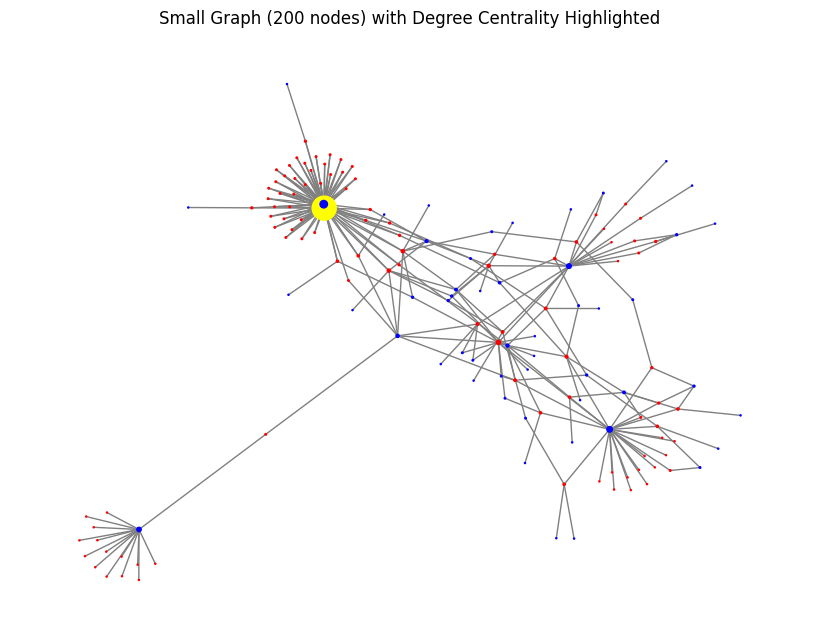

In [70]:
plot_graph_with_node_size(G_200_nodes, centralities_small["degree"], title="Small Graph (200 nodes) with Degree Centrality Highlighted", scale=100)


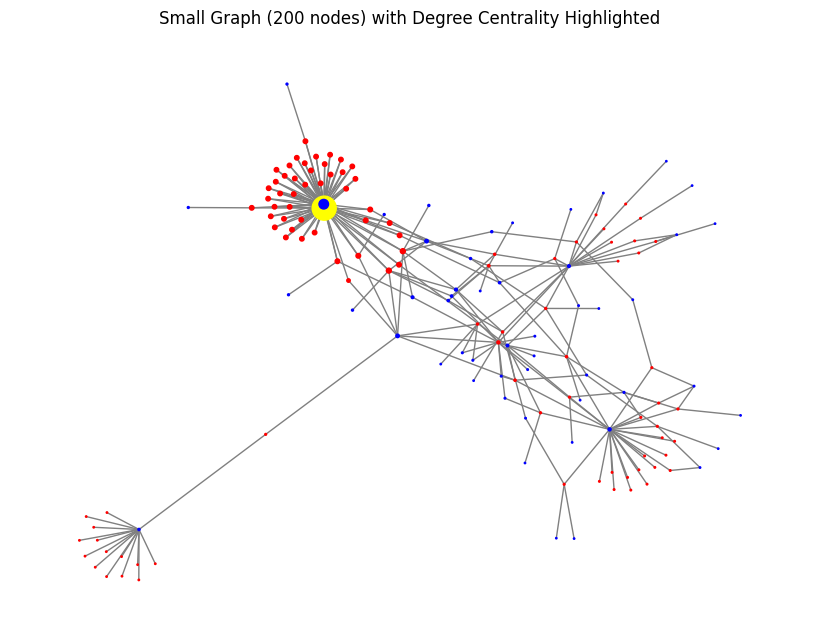

In [71]:
plot_graph_with_node_size(G_200_nodes, centralities_small["katz"], title="Small Graph (200 nodes) with Degree Centrality Highlighted", scale=100)


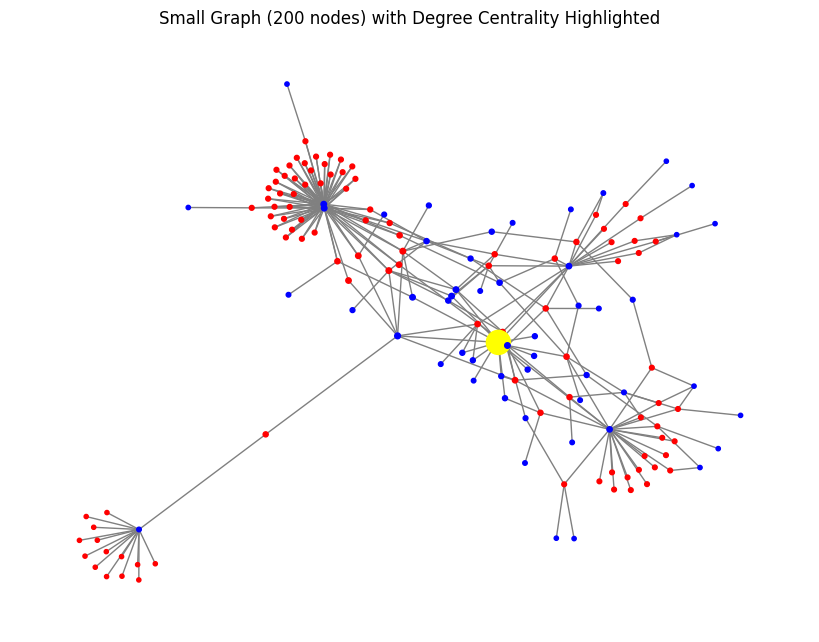

In [73]:
plot_graph_with_node_size(G_200_nodes, centralities_small["closeness"], title="Small Graph (200 nodes) with Degree Centrality Highlighted", scale=50)


# Community Detection

In [50]:
def plot_communities(G: nx.Graph, partition: dict, title: str = "Communities") -> None:
    """
    Plots the graph, coloring nodes by their 'community' (taken from partition dict)
    and differentiating diseases vs. genes by shape (circle vs. triangle).
    
    partition: dictionary {node: community_id} from a detection algorithm.
    """
    # Get node positions
    pos = nx.spring_layout(G, seed=42)
    
    # Map each community to a unique color
    communities = set(partition.values())
    # E.g. choose a color palette for up to, say, 20 communities:
    color_choices = plt.cm.get_cmap('tab20', len(communities))
    # Build a node list for each community
    community_color_map = {}
    for i, c in enumerate(sorted(communities)):
        community_color_map[c] = color_choices(i)

    # We will shape disease as 'o' and genes as '^'
    disease_nodes_by_comm = {}
    gene_nodes_by_comm = {}
    for node in G.nodes():
        comm_id = partition.get(node, 0)
        if G.nodes[node].get('category') == 'disease':
            disease_nodes_by_comm.setdefault(comm_id, []).append(node)
        else:
            gene_nodes_by_comm.setdefault(comm_id, []).append(node)
    
    # Plot
    plt.figure(figsize=(9, 7))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
    
    # For each community, draw disease nodes (circles) and gene nodes (triangles)
    for comm_id in communities:
        color = community_color_map[comm_id]
        # disease circle nodes
        d_nodes = disease_nodes_by_comm.get(comm_id, [])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=d_nodes,
                               node_color=[color]*len(d_nodes),
                               node_shape='o',
                               node_size=120,
                               label=f"Community {comm_id} - disease" if len(d_nodes)>0 else "")
        # gene triangular nodes
        g_nodes = gene_nodes_by_comm.get(comm_id, [])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=g_nodes,
                               node_color=[color]*len(g_nodes),
                               node_shape='^',
                               node_size=120,
                               label=f"Community {comm_id} - gene" if len(g_nodes)>0 else "")
    
    plt.title(title)
    plt.axis('off')
    plt.show()


In [51]:
def run_louvain(G: nx.Graph) -> dict:
    """
    Runs the Louvain community detection (python-louvain) on Graph G.
    Returns a dictionary {node: community_id}.
    """
    partition = community_louvain.best_partition(G)  # node -> community id
    return partition

def compute_modularity_louvain(G: nx.Graph, partition: dict) -> float:
    """
    Compute the modularity of a given partition (from Louvain) using python-louvain's modularity function.
    """
    # Convert G to the form needed by community_louvain (it can usually handle networkx Graph directly).
    # Then pass the partition dictionary directly.
    mod = community_louvain.modularity(partition, G)
    return mod

In [52]:
def run_girvan_newman_k_groups(G: nx.Graph, k: int = 4) -> dict:
    """
    Runs the Girvan–Newman approach to find a partition with k communities.
    Returns a dictionary {node: community_id}.
    We pick the partition at the iteration that yields k subsets.
    """
    gn_generator = nx.algorithms.community.girvan_newman(G)
    # girvan_newman yields partitions in order of increasing number of communities
    # We'll iterate until we get k communities, or we run out of partitions
    for partition_level in gn_generator:
        # partition_level is a tuple of sets, each set is a community
        if len(partition_level) == k:
            # Build a dict node-> community_id
            node2comm = {}
            for i, comm_set in enumerate(partition_level):
                for node in comm_set:
                    node2comm[node] = i
            return node2comm
    # If we never reached k communities, fallback to the last partition
    node2comm = {}
    # last partition from generator is not trivial to access once iter consumed,
    # so this approach just returns the best we can do.
    return node2comm

def compute_modularity_networkx(G: nx.Graph, partition: dict) -> float:
    """
    Compute modularity using networkx's built-in function:
      nx.algorithms.community.quality.modularity(G, communities)
    The partition must be a list of sets of nodes.
    """
    # Convert node->comm dictionary to a list of sets
    comm_map = {}
    for n, c in partition.items():
        comm_map.setdefault(c, set()).add(n)
    communities = list(comm_map.values())  # list of sets
    mod = nx.algorithms.community.quality.modularity(G, communities)
    return mod

Louvain found 8 communities. Modularity = 0.6212


C:\Users\merte\AppData\Local\Temp\ipykernel_21364\3244875216.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



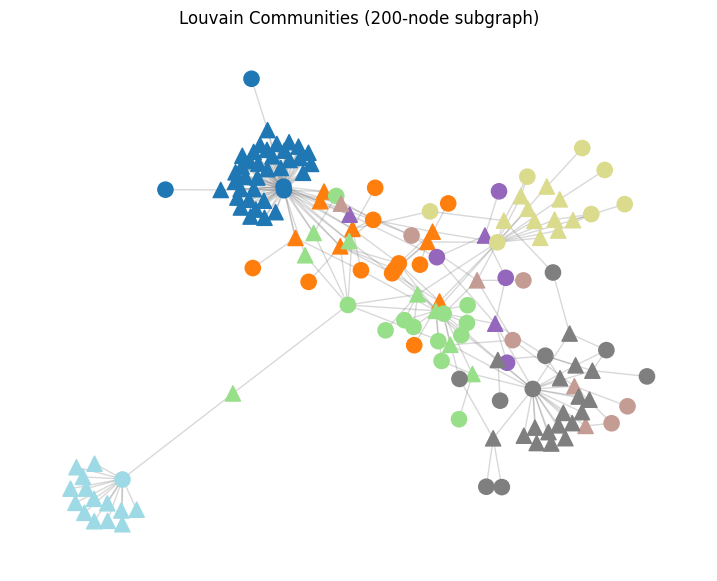

In [53]:
louvain_partition = run_louvain(G_200_nodes)
louvain_mod = compute_modularity_louvain(G_200_nodes, louvain_partition)
print(f"Louvain found {len(set(louvain_partition.values()))} communities. Modularity = {louvain_mod:.4f}")

# Visualize
plot_communities(G_200_nodes, louvain_partition, title="Louvain Communities (200-node subgraph)")



Girvan–Newman partition with 8 communities. Modularity = 0.60773011


C:\Users\merte\AppData\Local\Temp\ipykernel_21364\3244875216.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



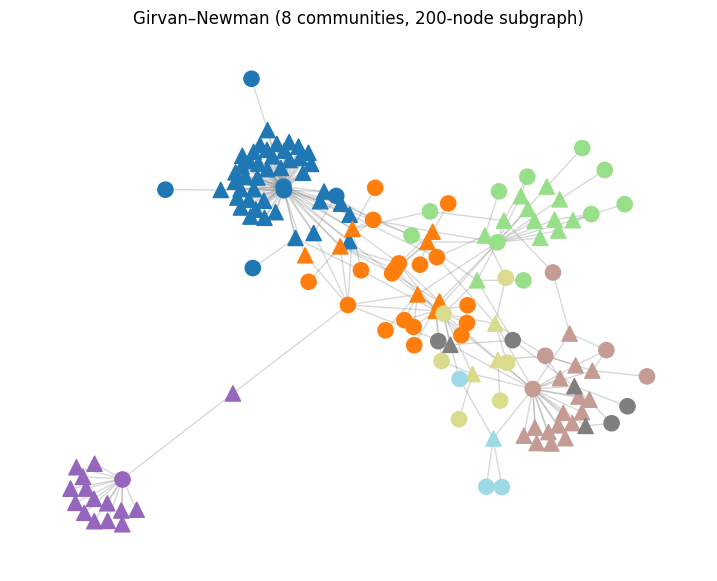

In [54]:
girvan_partition_8 = run_girvan_newman_k_groups(G_200_nodes, k=8)
if not girvan_partition_8:
    print("Girvan–Newman did not find 8 communities; maybe graph is too small or too disconnected.")
else:
    mod_8 = compute_modularity_networkx(G_200_nodes, girvan_partition_8)
    print(f"Girvan–Newman partition with 8 communities. Modularity = {mod_8:.8f}")
    plot_communities(G_200_nodes, girvan_partition_8, title="Girvan–Newman (8 communities, 200-node subgraph)")


Girvan–Newman partition with 3 communities. Modularity = 0.393


C:\Users\merte\AppData\Local\Temp\ipykernel_18020\3244875216.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_choices = plt.cm.get_cmap('tab20', len(communities))


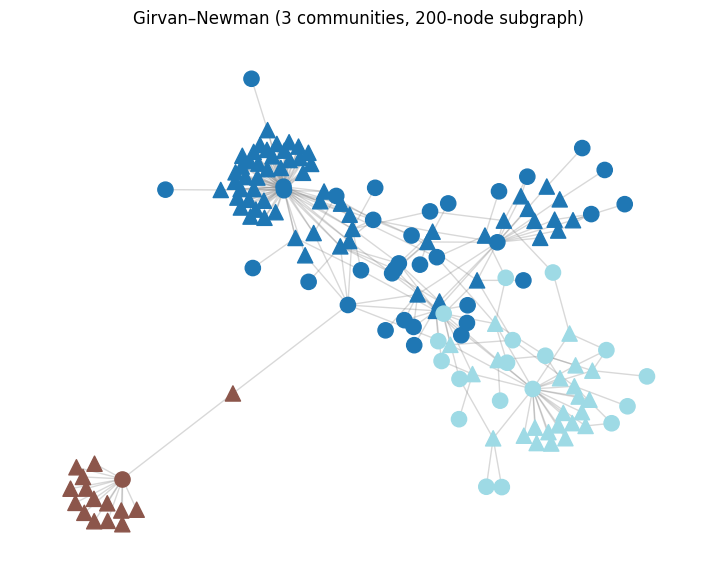

In [80]:
girvan_partition_3 = run_girvan_newman_k_groups(G_200_nodes, k=3)
if not girvan_partition_3:
    print("Girvan–Newman did not find 3 communities; maybe graph is too small or too disconnected.")
else:
    mod_3 = compute_modularity_networkx(G_200_nodes, girvan_partition_3)
    print(f"Girvan–Newman partition with 3 communities. Modularity = {mod_3:.3f}")
    plot_communities(G_200_nodes, girvan_partition_3, title="Girvan–Newman (3 communities, 200-node subgraph)")


In [17]:
def run_louvain_communities(G: nx.Graph):
    """
    Runs Louvain community detection on the graph and returns:
    - partition: dict {node: community_id}
    - communities: a dict {community_id: [list of nodes]}
    """
    partition = community_louvain.best_partition(G)
    community_groups = defaultdict(list)
    for node, comm_id in partition.items():
        community_groups[comm_id].append(node)
    return partition, dict(community_groups)


def plot_diseases_by_community_radial(G: nx.Graph, partition: dict,
                                      title: str = "Diseases by Louvain Community",
                                      radius: float = 8.0):
    """
    Plots ONLY the disease nodes, ignoring genes.
    Each Louvain community is placed around a circle in 2D, with disease names labeled.
    
    Args:
      G: the full heterogeneous graph
      partition: dict {node -> comm_id}, from Louvain
      title: plot title
      radius: radius for the circle on which we place each community
              (larger => more spread out clusters)
    """
    # Filter out disease nodes
    disease_nodes = [n for n in G.nodes if G.nodes[n].get('category') == 'disease']
    
    # Group disease nodes by community
    disease_by_comm = defaultdict(list)
    for node in disease_nodes:
        c_id = partition.get(node, 0)
        disease_by_comm[c_id].append(node)

    # Number of communities
    all_comms = sorted(disease_by_comm.keys())
    k = len(all_comms)

    # We'll arrange the communities in a ring around the origin, each at angle = i*(2*pi/k)
    # Then, within each community, we place nodes in a small circle around that community center
    # so they don't overlap.
    
    # We can define a cluster_radius smaller than 'radius' used to place each disease in that cluster
    cluster_radius = 1.5  # radius for sub-circle per community

    plt.figure(figsize=(12, 10))
    
    for i, comm_id in enumerate(all_comms):
        # Center for this community
        angle = 2.0 * np.pi * i / k
        center_x = radius * np.cos(angle)
        center_y = radius * np.sin(angle)

        # The disease nodes in this community
        nodes = disease_by_comm[comm_id]
        
        # Place them on a smaller circle (or random scatter) around (center_x, center_y)
        n_nodes = len(nodes)
        # For better separation, let's place each disease at an angle subdividing 2*pi
        # so they form a smaller ring
        for idx, node in enumerate(nodes):
            d_angle = 2.0 * np.pi * idx / max(n_nodes, 1)
            # final x, y
            final_x = center_x + cluster_radius * np.cos(d_angle)
            final_y = center_y + cluster_radius * np.sin(d_angle)

            disease_name = G.nodes[node].get('name', f"Disease_{node}")

            # Plot a point (small circle)
            plt.plot(final_x, final_y, 'o', color='darkblue', markersize=8)

            # Add a text label next to it
            plt.text(final_x+0.1, final_y, disease_name, fontsize=8,
                     va='center', color='black')

    plt.title(title)
    plt.axis('equal')        # so x and y scale are similar
    plt.axis('on')           # you can switch to off if you want no axes
    plt.show()


In [14]:
G_1000_nodes, num_d, num_g = create_hetero_graph_from_tsv('data_disease\DG-AssocMiner_miner-disease-gene.tsv', num_nodes_to_consider=1000)

In [15]:
%matplotlib ipympl

Louvain found 11 communities among 938 nodes.


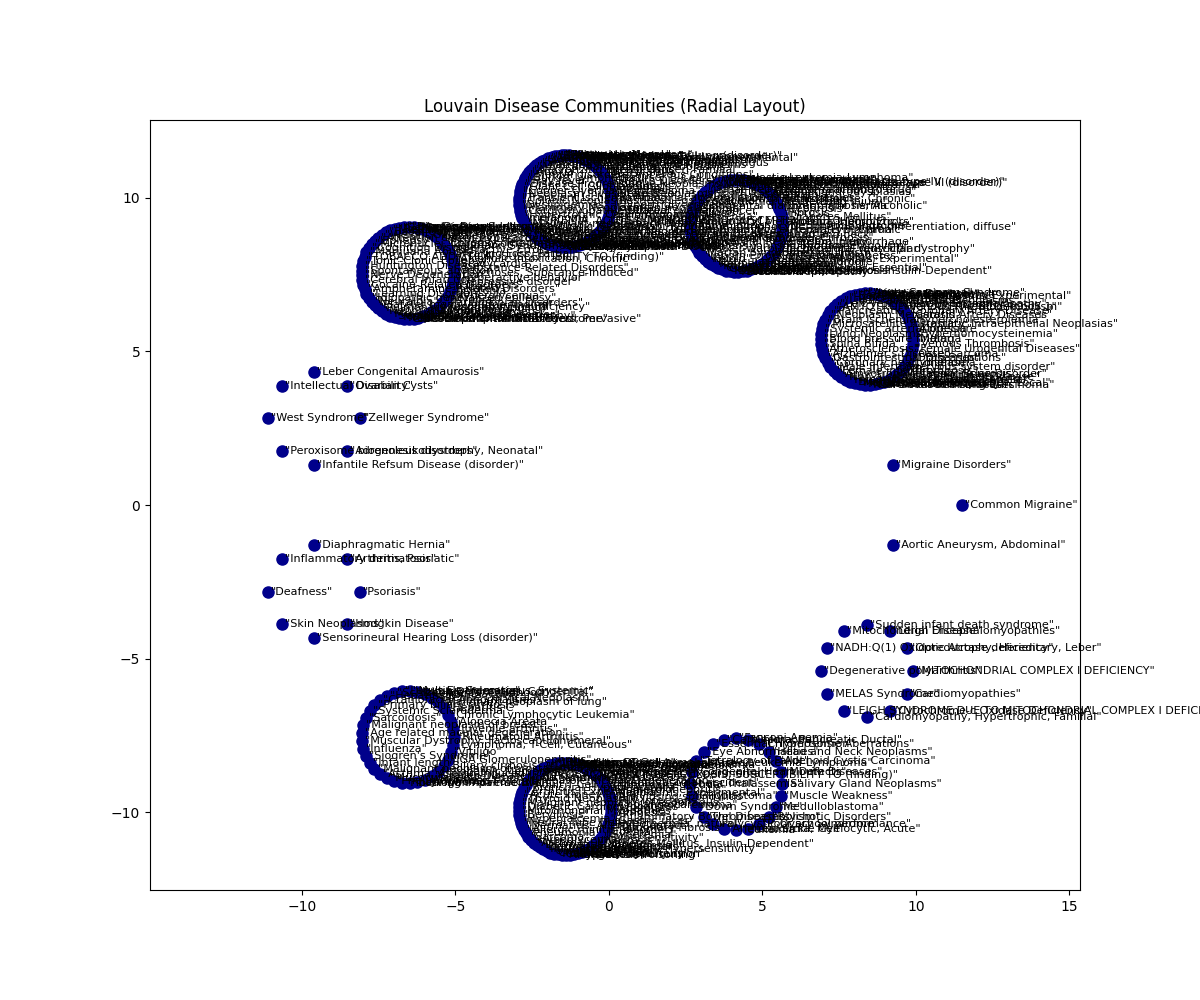

In [18]:
# 2) Louvain detection
partition, comm_groups = run_louvain_communities(G_1000_nodes)
print(f"Louvain found {len(comm_groups)} communities among {len(G_1000_nodes)} nodes.")

# 3) Plot diseases only in radial layout
plot_diseases_by_community_radial(G_1000_nodes, partition,
    title="Louvain Disease Communities (Radial Layout)",
    radius=10.0
)


# Graph Embedding

In [9]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [10]:
def compute_node2vec_embedding(G: nx.Graph, dimensions: int = 16,
                               walk_length: int = 80, num_walks: int = 10,
                               window_size: int = 5, p: float = 1.0, q: float = 1.0) -> np.ndarray:
    """
    Computes Node2Vec embeddings for each node in G.
    Returns a numpy array shape (num_nodes, dimensions).
    The order of rows will match sorted(G.nodes()).
    
    Args:
      dimensions: dimension of embedding
      walk_length: length of each random walk
      num_walks: number of random walks per node
      window_size: skip-gram window size
      p, q: node2vec hyperparameters controlling BFS vs DFS bias
    """
    # Node2Vec requires consistent node IDs. We'll pass the graph as is, but we'll
    # need to remember to index them in sorted order to build a final array.
    node_order = sorted(G.nodes())
    node_index_map = {node: i for i, node in enumerate(node_order)}
    
    # Initialize node2vec from node2vec library
    n2v = Node2Vec(G,
                   dimensions=dimensions,
                   walk_length=walk_length,
                   num_walks=num_walks,
                   p=p,
                   q=q,
                   workers=1,   # Adjust as needed
                   quiet=True   # suppress progress bar
                  )
    # Fit model
    n2v_model = n2v.fit(window=window_size, min_count=1, batch_words=4)
    
    # Build embedding array
    emb_array = np.zeros((len(node_order), dimensions), dtype=np.float32)
    for node in node_order:
        emb_array[node_index_map[node]] = n2v_model.wv[str(node)]
    
    return emb_array, node_order


In [11]:
def compute_spectral_embedding(G: nx.Graph, k: int = 16) -> np.ndarray:
    """
    Computes a Laplacian-based spectral embedding of dimension k for each node in G.
    
    Returns:
      A numpy array of shape (num_nodes, k), where each row is the embedding of that node.
      The order of rows corresponds to sorted(G.nodes()) for consistency.
    """
    # 1) We need a consistent node ordering
    nodes_sorted = sorted(G.nodes())
    node_index_map = {node: idx for idx, node in enumerate(nodes_sorted)}
    n = len(nodes_sorted)
    
    # 2) Build adjacency matrix or Laplacian
    # For large graphs, you might consider a sparse approach (scipy.sparse).
    A = np.zeros((n, n), dtype=np.float32)
    for u, v in G.edges():
        i, j = node_index_map[u], node_index_map[v]
        A[i, j] = 1
        A[j, i] = 1
    
    # 3) Compute the (normalized) Laplacian: L = D - A, or the symmetric normalized version
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(degrees, 1e-9)))
    I = np.eye(n)
    L = I - (D_inv_sqrt @ A @ D_inv_sqrt)  # Symmetric normalized Laplacian = I - D^-1/2 * A * D^-1/2
    
    # 4) Compute the bottom k+1 eigenvectors of L. We typically skip the first eigenvector (the trivial 0 eigenvalue).
    # We can use np.linalg.eigh, but be mindful of memory for large n. For a smaller or moderate graph this is okay.
    w, v = np.linalg.eigh(L)  # w: eigenvals, v: eigenvecs
    # Eigenvalues/eigenvectors are sorted in ascending order by w
    # Typically the 0 eigenvalue is w[0], so let's skip the first and take next k
    # However, note that if the graph is not fully connected, there might be multiple 0 eigenvalues.
    
    # We'll pick the smallest k non-trivial eigenvectors. We'll skip the first eigenvector if it's the trivial one.
    # If we want exactly k dims, we can skip the first dimension with w=0, then take next k. We can also detect how many 0's are present
    # For simplicity, let's skip the first vector and take the next k:
    embedding = v[:, 1:(1 + k)]
    
    # embedding shape is (n, k). Each row i is the embedding for node nodes_sorted[i].
    return embedding, nodes_sorted


In [12]:
def compute_silhouette(embeddings: np.ndarray, labels: np.ndarray) -> float:
    """
    Computes the silhouette score for the given embeddings (dim = NxD)
    with a label array of shape (N,). Typically in classification,
    a higher silhouette means better separation among classes.
    """
    if len(np.unique(labels)) < 2:
        return -1  # silhouette needs >= 2 clusters
    return silhouette_score(embeddings, labels)

In [13]:
def get_category_labels(G: nx.Graph, node_order: list) -> np.ndarray:
    """
    Returns an array of labels: 0 for disease, 1 for gene, in the node_order.
    """
    labs = []
    for node in node_order:
        cat = G.nodes[node].get('category')
        labs.append(0 if cat == 'disease' else 1)
    return np.array(labs)


In [14]:
from sklearn.manifold import TSNE

def reduce_to_2d(embeddings: np.ndarray, method: str = "pca") -> np.ndarray:
    """
    Reduces embeddings to 2D with PCA or t-SNE.
    Returns an array shape (num_nodes, 2).
    """
    if method.lower() == "pca":
        pca = PCA(n_components=2)
        coords_2d = pca.fit_transform(embeddings)
    else:
        # fallback t-SNE
        tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
        coords_2d = tsne.fit_transform(embeddings)
    return coords_2d

def plot_embeddings_2d(coords_2d: np.ndarray, G: nx.Graph, node_order: list, title: str = "") -> None:
    """
    Creates a scatter plot of the 2D coordinates, coloring by category (disease vs. gene).
    node_order matches the row ordering of coords_2d.
    """
    # Identify diseases vs. genes
    categories = []
    for node in node_order:
        cat = G.nodes[node].get('category', 'unknown')
        categories.append(cat)
    
    xs = coords_2d[:, 0]
    ys = coords_2d[:, 1]
    
    # We'll color diseases in blue, genes in red
    colors = ['blue' if cat=='disease' else 'red' for cat in categories]
    
    plt.figure(figsize=(8,6))
    plt.scatter(xs, ys, c=colors, alpha=0.7, s=10)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()



## Visualization of the Embeddings and Silhioute Score

In [24]:
spectral_embed, node_order = compute_spectral_embedding(G, k=16)
print("Spectral embedding shape:", spectral_embed.shape)


Spectral embedding shape: (7813, 16)


The spectral embedding can't distringuish what is a gene and what is a disease, but the result is better than the Node2Vec embeddings

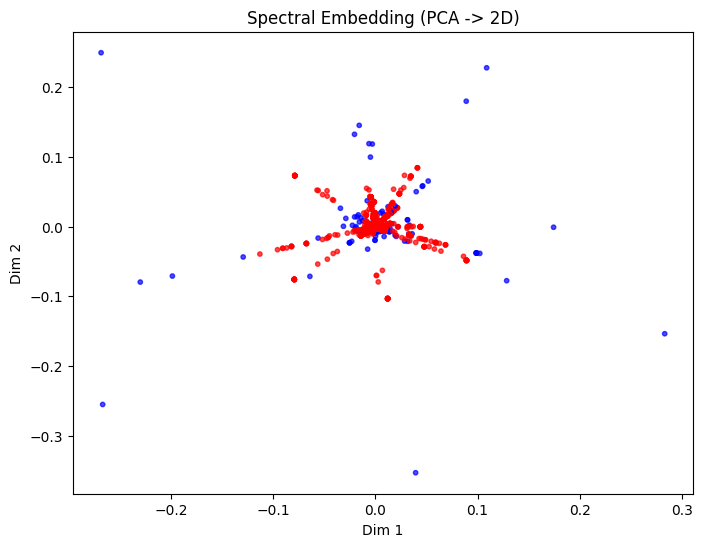

In [14]:
spec_coords_2d_pca = reduce_to_2d(spectral_embed, method="pca")
plot_embeddings_2d(spec_coords_2d_pca, G, node_order, title="Spectral Embedding (PCA -> 2D)")

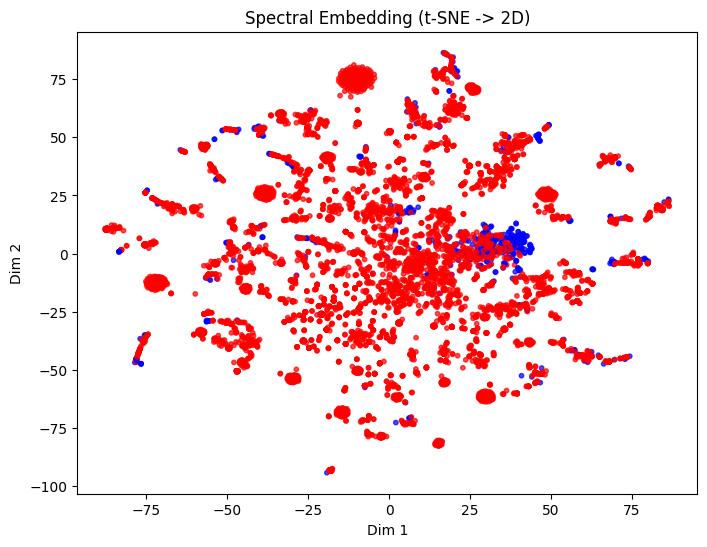

In [15]:
spec_coords_2d_tsne = reduce_to_2d(spectral_embed, method="tsne")
plot_embeddings_2d(spec_coords_2d_tsne, G, node_order, title="Spectral Embedding (t-SNE -> 2D)")

In [28]:
labels_spectral = get_category_labels(G, node_order)
sil_spec = compute_silhouette(spectral_embed, labels_spectral)
print(f"Spectral embeddings: silhouette wrt disease/gene = {sil_spec:.4f}")

Spectral embeddings: silhouette wrt disease/gene = 0.6123


In [15]:
n2v_embed, node_order_2 = compute_node2vec_embedding(
    G, dimensions=16, walk_length=80, num_walks=10,
    window_size=5, p=1.0, q=1.0
)
print("Node2Vec embedding shape:", n2v_embed.shape)


Node2Vec embedding shape: (7813, 16)


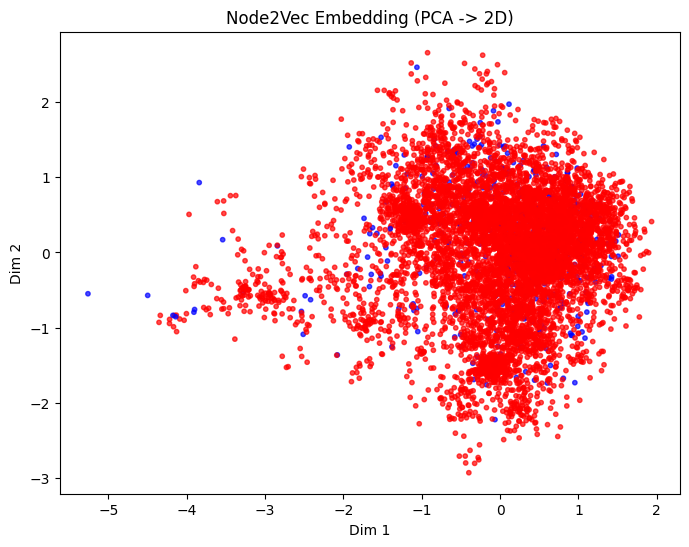

In [16]:
n2v_coords_2d_pca = reduce_to_2d(n2v_embed, method="pca")
plot_embeddings_2d(n2v_coords_2d_pca, G, node_order_2, title="Node2Vec Embedding (PCA -> 2D)")


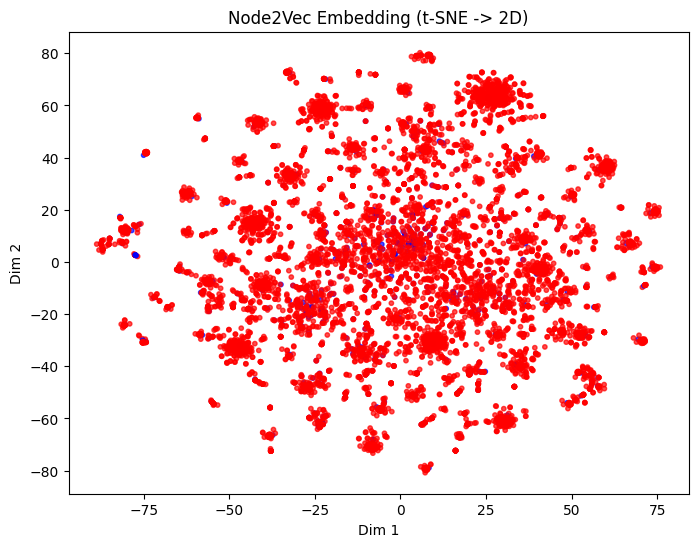

In [17]:
n2v_coords_2d_tsne = reduce_to_2d(n2v_embed, method="tsne")
plot_embeddings_2d(n2v_coords_2d_tsne, G, node_order_2, title="Node2Vec Embedding (t-SNE -> 2D)")


In [32]:
labels_nod2vec = get_category_labels(G, node_order_2)
sil_n2v = compute_silhouette(n2v_embed, labels_nod2vec)
print(f"Node2Vec embeddings: silhouette wrt disease/gene = {sil_n2v:.4f}")

Node2Vec embeddings: silhouette wrt disease/gene = -0.0374


## Community based on embeddigns

In [34]:
def find_similar_nodes(target_name: str, embeddings: np.ndarray, 
                       node_order: list, G: nx.Graph, top_n: int = 5) -> None:
    """
    Finds and prints the top_n nodes in the embedding space that are most similar to
    the node with a given target name (using Euclidean distance).

    Args:
      target_name: string, the name of the target node (e.g., "Mammary Neoplasms")
      embeddings: numpy array of shape (n_samples, n_features).
      node_order: list of node IDs corresponding to the rows in embeddings.
      G: the original graph with node attribute "name".
      top_n: the number of similar nodes to print.
    """
    # Locate the target node index in node_order
    target_idx = None
    for idx, node in enumerate(node_order):
        if G.nodes[node].get('name', "").lower() == target_name.lower():
            target_idx = idx
            break

    if target_idx is None:
        print(f"Target node with name '{target_name}' not found.")
        return

    target_embedding = embeddings[target_idx, :]
    # Compute Euclidean distances from target to all other nodes.
    diffs = embeddings - target_embedding  # shape (n, d)
    dists = np.linalg.norm(diffs, axis=1)
    
    # Get indices sorted by distance (excluding the target itself).
    sorted_indices = np.argsort(dists)
    similar_indices = [i for i in sorted_indices if i != target_idx][:top_n]

    print(f"Nodes most similar to '{target_name}':")
    for idx in similar_indices:
        node = node_order[idx]
        name = G.nodes[node].get('name', f"Node {node}")
        category = G.nodes[node].get('category', "unknown")
        dist = dists[idx]
        print(f"  {name} (ID: {node}, Category: {category}) with distance {dist:.4f}")


In [42]:
find_similar_nodes('"Mammary Neoplasms"', spectral_embed, node_order, G, top_n=5)

Nodes most similar to '"Mammary Neoplasms"':
  "Liver carcinoma" (ID: 311, Category: disease) with distance 0.0133
  "Neoplasm Metastasis" (ID: 485, Category: disease) with distance 0.0136
  "Neoplastic Cell Transformation" (ID: 1037, Category: disease) with distance 0.0140
  "Adenocarcinoma" (ID: 273, Category: disease) with distance 0.0141
  "Prostatic Neoplasms" (ID: 239, Category: disease) with distance 0.0142


In a bipartite graph, since the walker is forced to alternate between node sets, the typical role of p and q (which guide exploration vs. exploitation) may need recalibration. The alternating structure means that the local context of a node will always include nodes of the other type.

With that in mind, Node2Vec may be better for a link prediction



In [43]:
find_similar_nodes('"Mammary Neoplasms"', n2v_embed, node_order_2, G, top_n=5)

Nodes most similar to '"Mammary Neoplasms"':
  6199 (ID: 10648, Category: gene) with distance 0.3505
  406914 (ID: 10600, Category: gene) with distance 0.3849
  6518 (ID: 10658, Category: gene) with distance 0.4093
  138046 (ID: 10532, Category: gene) with distance 0.4107
  56942 (ID: 10628, Category: gene) with distance 0.4207


With GNNs, we will explain better what are those genes by merging outside data

# GNN

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T

from plotly import graph_objs as go
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree


In [4]:
# set the seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

We want to assign each node a unique integer index. So, the 519 disease nodes would be indexed 0 through 518, and the 7294 gene nodes would be indexed 519 through 7812.

The edge index list is a list of pairs (x1, x2), where x1 is the index of the head node and x2 is the index of the tail node.

We create both the edge index and a reverse edge index, which is necessary for undirected graphs

In [5]:
def load_node_mapping(datafile_path, index_col, offset=0):
  """
  Maps each distinct node to a unique integer index.

  Args: datafile_path, string name of the tsv file containing the graph data
        index_col, string name of the column containing the nodes of concern
        offset, amount to shift the generated indexes by
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, index_col=index_col, sep="\t")
  mapping = {index_id: i + offset for i, index_id in enumerate(df.index.unique())}
  return mapping

def load_edge_list(datafile_path, src_col, src_mapping, dst_col, dst_mapping):
  """
  Given node mappings, returns edge list in terms of node integer indices.

  Args: datafile_path, string name of the tsv file containing the graph data
        src_col, string name of the column corresponding to source nodes
        src_mapping, mapping from source node name to integer index
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, sep="\t")
  src_nodes = [src_mapping[index] for index in df[src_col]]
  dst_nodes = [dst_mapping[index] for index in df[dst_col]]
  edge_index = torch.tensor([src_nodes, dst_nodes])
  return edge_index

def initialize_data(datafile_path, num_features=1):
  """
  Given a tsv file specifying disease-gene interactions, index the nodes and
  construct a Data object.
  """
  # Get disease node mapping and gene node mapping.
  # Each node type has its own set of integer ids.
  dz_col, gene_col = "# Disease ID", "Gene ID"
  dz_mapping = load_node_mapping(datafile_path, dz_col, offset=0)
  gene_mapping = load_node_mapping(datafile_path, gene_col, offset=519)

  # Get edge index in terms of the integer indeces assigned to the nodes.
  edge_index = load_edge_list(
      datafile_path, dz_col, dz_mapping, gene_col, gene_mapping)

  # Add the reverse direction (aka make it a undirected graph)
  rev_edge_index = load_edge_list(
      datafile_path, gene_col, gene_mapping, dz_col, dz_mapping)

  # Construct a Data object.
  data = Data()
  data.num_nodes = len(dz_mapping) + len(gene_mapping)
  data.edge_index = torch.cat((edge_index, rev_edge_index), dim=1)
  # pretend we have uniform node features
  data.x = torch.ones((data.num_nodes, num_features))

  return data, gene_mapping, dz_mapping

In [6]:
# Read data and construct Data object.
data_object, gene_mapping, dz_mapping = initialize_data('data_disease\DG-AssocMiner_miner-disease-gene.tsv')
print(data_object)
print("Number of genes:", len(gene_mapping))
print("Number of diseases:", len(dz_mapping))

Data(num_nodes=7813, edge_index=[2, 42714], x=[7813, 1])
Number of genes: 7294
Number of diseases: 519


## Dataset Configuration

In [7]:
NUM_FEATURES = 20

Since we don't have any features, we will initiate a dummy embedding

In [8]:
data_object.x = torch.ones((data_object.num_nodes, NUM_FEATURES))
print("Using dummy embeddings as initial node features.")
print("Number of features set to ", NUM_FEATURES)

Using dummy embeddings as initial node features.
Number of features set to  20


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

train_dataset, val_dataset, test_dataset = transform(data_object)
print("Train Data:\n", train_dataset)
print("Validation Data:\n", val_dataset)
print("Test Data:\n", test_dataset)

Train Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])
Validation Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[1067], pos_edge_label_index=[2, 1067], neg_edge_label=[1067], neg_edge_label_index=[2, 1067])
Test Data:
 Data(num_nodes=7813, edge_index=[2, 36308], x=[7813, 20], pos_edge_label=[3203], pos_edge_label_index=[2, 3203], neg_edge_label=[3203], neg_edge_label_index=[2, 3203])


## Analysis and Plots

In [11]:
def get_mapping():
  data_path = "data_disease\DG-AssocMiner_miner-disease-gene.tsv"
  df = pd.read_csv(data_path, index_col="Disease Name", sep="\t")
  disease_mapping = [index_id for index_id in enumerate(df.index.unique())]
  df = pd.read_csv(data_path, index_col="Gene ID", sep="\t")
  gene_mapping = [index_id[1] for index_id in enumerate(df.index.unique())]
  mapping = disease_mapping + gene_mapping
  return mapping

def visualize_tsne_embeddings(model, data, title, perplexity=30.0,
                              labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with t-SNE.

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
        perplexity, t-SNE hyperparameter for perplexity
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)
  ax1, ax2 = zip(*TSNE(n_components=2, learning_rate='auto', perplexity=perplexity,
                       init='random').fit_transform(z.detach().cpu().numpy()))

  fig = px.scatter(x=ax1, y=ax2, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()],
                   title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=ax1[i], y=ax2[i],
                         text=str(i), showarrow=False)
  fig.show()

def visualize_pca_embeddings(model, data, title, labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with PCA (components=2)

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)

  pca = PCA(n_components=2)
  components = pca.fit_transform(z.detach().cpu().numpy())
  fig = px.scatter(components, x=0, y=1, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()], title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=components[:,0][i], y=components[:,1][i],
                         text=str(i), showarrow=False)
  fig.show()

In [12]:
def plot_roc_curve(model, data):
  """Visualizes ROC curve of model predictions

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
  """
  model.eval()

  x = data.x
  z = model.encode(x, data.edge_index)

  pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
  neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
  preds = torch.cat([pos_preds, neg_preds], dim=0)
  preds = preds.detach().cpu().numpy()

  labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
  labels = labels.detach().cpu().numpy()
  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

  # Using J-statistic: https://en.wikipedia.org/wiki/Youden%27s_J_statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))

  roc_auc = metrics.roc_auc_score(labels, preds)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--') # diagonal roc curve of a random classifier
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc = 'lower right')
  plt.title('ROC curve for model predictions')
  plt.show()

In [13]:
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap):
  """Plots evolution of loss and metrics during training

  Args: losses, test_auc, test_ap, train_auc, and train_ap should be lists
    outputted by the training process.
  """
  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  plt.show()

In [31]:
def get_edge_dot_products(data, model, num_dz_nodes=519):
  """
  A pair of nodes (u,v) is predicted to be connected with an edge if the dot
  product between the learned embeddings of u and v is high. This function
  computes and returns the dot product of all pairs of (dz_node, gene_node).

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    dot_products, a numpy 2D array of shape (num_dz_nodes, num_gene_nodes)
      containing the dot product between each (dz_node, gene_node) pair.
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().cpu().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=519):
  """
  Ranks all potential edges as predicted by the model.

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    ranked_edge_list, a full edge list ranked by the likelihood of the edge
      being a positive edge, in decreasing order
    ranked_dot_products, a list of the dot products of each edge's node
      embeddings, ranked in decreasing order
  """
  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


## Train GAE

In [15]:
HIDDEN_SIZE = 200

OUT_CHANNELS = 20

EPOCHS =   40

In [16]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)


gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
gae_model = gae_model.to(device)

In the training loop, we optimize the model based on its reconstruction loss, a loss function provided by PyG. Roughly speaking, it calculates the difference between the output of the model's encoder and the true adjacency matrix of the graph, in hopes that minimizing this will help the model learn a meaningful encoding of the graph.

In [17]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)


Before we train the model, let's visualize how the encoder initially embeds the nodes. Here, we are using t-SNE and PCA to project the embeddings into a 2D space. We use red for the disease nodes and blue for the gene nodes (note that the red nodes can overlap over the blue nodes).

We also labeled some nodes throughout these visualizations to provide some sense of how the nodes' embeddings evolve throughout this process. For example, node 280 is a disease node of high degree, and thus tends to be more separated from the rest of the nodes in the PCA visualizations - farther distance from the other nodes means higher dot products with the other nodes' embeddings, which means the decoder would predict more edges with this high degree node.

In [18]:
visualize_tsne_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings t-SNE', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [19]:
visualize_pca_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings PCA', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [20]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []


optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)

for epoch in range(1, EPOCHS + 1):
    loss = gae_train(train_dataset, gae_model, optimizer)

    losses.append(float(loss))
    auc, ap = gae_test(test_dataset, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_dataset, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.9458, test AP: 0.9429, train AUC: 0.9472, train AP: 0.9420, loss:2.1079
Epoch: 002, test AUC: 0.9456, test AP: 0.9428, train AUC: 0.9470, train AP: 0.9419, loss:2.0210
Epoch: 003, test AUC: 0.9450, test AP: 0.9423, train AUC: 0.9464, train AP: 0.9414, loss:1.5058
Epoch: 004, test AUC: 0.9443, test AP: 0.9418, train AUC: 0.9456, train AP: 0.9408, loss:1.2789
Epoch: 005, test AUC: 0.9436, test AP: 0.9412, train AUC: 0.9449, train AP: 0.9402, loss:1.2485
Epoch: 006, test AUC: 0.9428, test AP: 0.9406, train AUC: 0.9440, train AP: 0.9394, loss:1.2298
Epoch: 007, test AUC: 0.9420, test AP: 0.9399, train AUC: 0.9432, train AP: 0.9387, loss:1.2294
Epoch: 008, test AUC: 0.9412, test AP: 0.9393, train AUC: 0.9423, train AP: 0.9380, loss:1.2112
Epoch: 009, test AUC: 0.9406, test AP: 0.9388, train AUC: 0.9417, train AP: 0.9375, loss:1.2054
Epoch: 010, test AUC: 0.9401, test AP: 0.9385, train AUC: 0.9412, train AP: 0.9371, loss:1.2081
Epoch: 011, test AUC: 0.9400, test AP: 0

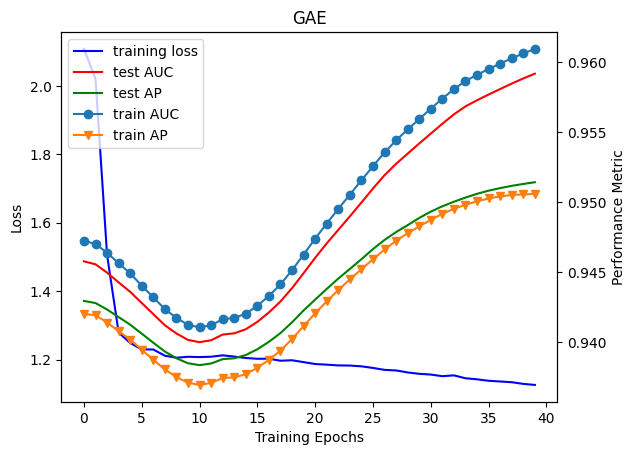

In [21]:
plot_training_stats('GAE', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.615489


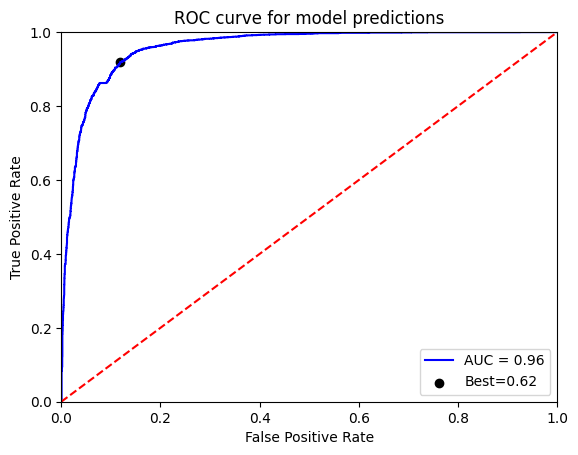

In [22]:
plot_roc_curve(gae_model, test_dataset)

In [23]:
visualize_tsne_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    perplexity=5, labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

As shown, by the end of training, the node embeddings have shifted to form more visible clusters differentiating gene and disease nodes. Remember, we haven’t passed anything to the model that indicates there are two types of nodes (disease and genes), as we are using a constant node feature for all nodes. The model learns on its own from the graph connectivity information that it is a bipartite graph!

In [24]:
visualize_pca_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

## Use model to do predictions

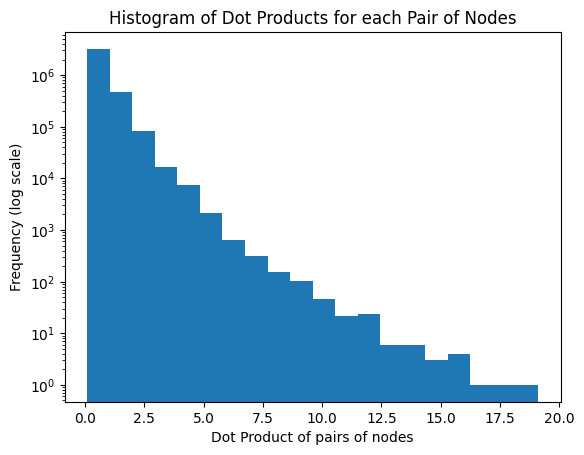

In [33]:
# Get ranked edge list, filtered by the selected node ids.
ranked_edge_list, ranked_dot_products = get_ranked_edges(data_object, gae_model)

# Plot histogram of the dot products
plt.hist(ranked_dot_products, bins=20)
plt.title("Histogram of Dot Products for each Pair of Nodes")
plt.yscale('log')
plt.ylabel("Frequency (log scale)")
plt.xlabel("Dot Product of pairs of nodes")
plt.show()

To better understand what the final embeddings represent, we can look at specific data points. For instance, the BRCA1 and BRCA2 genes are well-studied in the medical literature — mutations in these genes are strongly linked to breast cancer.

### Load extra data

In [38]:
df = pd.read_csv('data_disease\DG-AssocMiner_miner-disease-gene.tsv', sep="\t")
print(df.head(), '\n')

  # Disease ID              Disease Name  Gene ID
0     C0036095  Salivary Gland Neoplasms     1462
1     C0036095  Salivary Gland Neoplasms     1612
2     C0036095  Salivary Gland Neoplasms      182
3     C0036095  Salivary Gland Neoplasms     2011
4     C0036095  Salivary Gland Neoplasms     2019 



In [39]:
gene_ids_data_path = "data_disease\gene_ids.tsv"

gene_ids_df = pd.read_csv(gene_ids_data_path, sep="\t")
gene_ids_df = gene_ids_df.rename(columns={
    "Gene stable ID": "ENSEMBL Gene ID",
    "Gene stable ID version": "ENSEMBL Gene ID Version",
    "NCBI gene (formerly Entrezgene) ID": "Gene ID"})
gene_ids_df = gene_ids_df.loc[:, ["ENSEMBL Gene ID", "Gene ID"]]

# Add new "ENSEMBL Gene ID" column to our existing Gene-Disease Assoc table.
new_df = pd.merge(df, gene_ids_df, left_on="Gene ID", right_on="Gene ID", how="left")
new_df["Gene ID"] = new_df["Gene ID"].astype(int)
print(new_df.loc[:, ["Gene ID", "ENSEMBL Gene ID", ]])  # To confirm mapping.


# Check how many NCBI Gene IDs were unable to be mapped to ENSEMBL Genes IDs.
print("Number of unmapped NCBI Genes:",
      new_df.drop_duplicates(subset="Gene ID")['ENSEMBL Gene ID'].isna().sum())

       Gene ID  ENSEMBL Gene ID
0         1462  ENSG00000038427
1         1612  ENSG00000196730
2          182  ENSG00000101384
3         2011  ENSG00000072518
4         2019  ENSG00000163064
...        ...              ...
25330     8848  ENSG00000102804
25331     9076  ENSG00000163347
25332      947  ENSG00000174059
25333     9839  ENSG00000169554
25334      999  ENSG00000039068

[25335 rows x 2 columns]
Number of unmapped NCBI Genes: 379


In [40]:
# This table contains info on a select set of genes, with each gene identified
# via their ENSEMBL Gene Id or HGNC Id. We would like to use the "name" as the
# short description of the gene.
data_path = "data_disease\G-SynMiner_miner-geneHUGO.tsv"
genes_df = pd.read_csv(data_path, sep="\t")
# print('\n', genes_df.loc[:,["# ensembl_gene_id", "name"]])

# Add the appropriate "name" data to the dataframe for each gene.
full_df = pd.merge(
    new_df, genes_df, left_on="ENSEMBL Gene ID",
    right_on="# ensembl_gene_id", how="left")

# Cut out any extraneous columns from the data frame and rename for easier use.
full_df = full_df.loc[:, ['# Disease ID', 'Disease Name', 'Gene ID', 'name']]
full_df = full_df.rename(columns={
    '# Disease ID': "Disease ID",
    'Disease Name': "Disease Name",
    'Gene ID': "Gene ID",
    'name': "Gene Name",
})

# print(full_df)
# print(full_df.columns)
print("Gene ID <-> Gene Name:\n", full_df.loc[:, ["Gene ID", "Gene Name"]], '\n')

num_nan_ensembl = new_df.drop_duplicates(subset="Gene ID")['ENSEMBL Gene ID'].isna().sum()
num_nan_desc = full_df.drop_duplicates(subset="Gene ID")["Gene Name"].isna().sum()
print("Number of missing ENSEMBL Gene IDs:", num_nan_ensembl)
print("Number of missing gene names:", num_nan_desc)

Gene ID <-> Gene Name:
        Gene ID                                 Gene Name
0         1462                                  versican
1         1612         death associated protein kinase 1
2          182                                  jagged 1
3         2011  microtubule affinity regulating kinase 2
4         2019                      engrailed homeobox 1
...        ...                                       ...
25330     8848              TSC22 domain family member 1
25331     9076                                 claudin 1
25332      947                             CD34 molecule
25333     9839      zinc finger E-box binding homeobox 2
25334      999                                cadherin 1

[25335 rows x 2 columns] 

Number of missing ENSEMBL Gene IDs: 379
Number of missing gene names: 905


C:\Users\merte\AppData\Local\Temp\ipykernel_21364\1005891739.py:5: DtypeWarning:

Columns (32,34,38) have mixed types. Specify dtype option on import or set low_memory=False.



In [41]:
full_df

Disease ID                    Disease Name  Gene ID  \
0       C0036095        Salivary Gland Neoplasms     1462   
1       C0036095        Salivary Gland Neoplasms     1612   
2       C0036095        Salivary Gland Neoplasms      182   
3       C0036095        Salivary Gland Neoplasms     2011   
4       C0036095        Salivary Gland Neoplasms     2019   
...          ...                             ...      ...   
25330   C0007621  Neoplastic Cell Transformation     8848   
25331   C0007621  Neoplastic Cell Transformation     9076   
25332   C0007621  Neoplastic Cell Transformation      947   
25333   C0007621  Neoplastic Cell Transformation     9839   
25334   C0007621  Neoplastic Cell Transformation      999   

                                      Gene Name  
0                                      versican  
1             death associated protein kinase 1  
2                                      jagged 1  
3      microtubule affinity regulating kinase 2  
4                          engrailed homeobox 1  
...                                         ...  
25330              TSC22 domain family member 1  
25331                                 claudin 1  
25332                             CD34 molecule  
25333      zinc finger E-box binding homeobox 2  
25334                                cadherin 1  

[25335 rows x 4 columns]

### Prediction

In [34]:
# Select for particular examples
select_gene_substrings = ["BRCA"]
select_disease_substrings = ['neoplasm']

In [42]:
# Filter data frame by the selected disease terms, and get their node ids.
if select_disease_substrings:
  dz_regex = "(?i)" + "|".join(select_disease_substrings)
  query_df = full_df[full_df['Disease Name'].str.contains(dz_regex)]
  query_dz_nodes = [dz_mapping[dz_id] for dz_id in query_df['Disease ID'].drop_duplicates().tolist()]
  # print("\nQueried Disease Nodes:\n", query_df['Disease Name'])
else:
  query_dz_nodes = None

# Filter data frame by the selected gene terms, and get their node ids.
if select_gene_substrings:
  gene_regex = "(?i)" + "|".join(select_gene_substrings)
  query_df = full_df[full_df['Gene Name'].notna()]
  query_df = query_df[query_df['Gene Name'].str.contains(gene_regex)]
  query_gene_nodes = [gene_mapping[gene_id] for gene_id in query_df['Gene ID'].drop_duplicates().tolist()]
  # print("\nQueried Gene Nodes:\n", query_df['Gene Name'])
else:
  query_gene_nodes = None


# Get reverse dz and gene mappings, to print out all needed info.
reverse_dz_mapping = {j: i for i,j in dz_mapping.items()}
reverse_gene_mapping = {j: i for i,j in gene_mapping.items()}

print("\nTop Predicted Edges")
top_k = 50
curr_k = 0
for dz_i, gene_i in ranked_edge_list:
  # Skip edges that do not include the selected dz and gene nodes
  if query_dz_nodes and dz_i not in query_dz_nodes:
    continue
  if query_gene_nodes and gene_i not in query_gene_nodes:
    continue

  # Get all the info needed (dz_i and gene_i are the node indeces)
  dz_id, gene_id = reverse_dz_mapping[dz_i], reverse_gene_mapping[gene_i]
  dz_description = full_df[full_df["Disease ID"] == dz_id]["Disease Name"].drop_duplicates().iloc[0]
  gene_description = full_df[full_df["Gene ID"] == gene_id]["Gene Name"].drop_duplicates().iloc[0]
  dot_product = ranked_dot_products[curr_k]

  print('edge=({},{}), \t dotprod={:.2f},\t descriptions=({},{})'.format(dz_i, gene_i, dot_product, dz_description, gene_description))

  curr_k += 1
  if curr_k > top_k:
    break


Top Predicted Edges
edge=(119,1108), 	 dotprod=19.11,	 descriptions=(Prostatic Neoplasms,BRCA1 associated protein 1)
edge=(280,1108), 	 dotprod=17.80,	 descriptions=(Mammary Neoplasms,BRCA1 associated protein 1)
edge=(119,2545), 	 dotprod=16.96,	 descriptions=(Prostatic Neoplasms,partner and localizer of BRCA2)
edge=(479,1108), 	 dotprod=15.79,	 descriptions=(Stomach Neoplasms,BRCA1 associated protein 1)
edge=(91,1108), 	 dotprod=15.44,	 descriptions=(Colorectal Neoplasms,BRCA1 associated protein 1)
edge=(280,2545), 	 dotprod=15.44,	 descriptions=(Mammary Neoplasms,partner and localizer of BRCA2)
edge=(119,2546), 	 dotprod=15.33,	 descriptions=(Prostatic Neoplasms,BRCA1 interacting protein C-terminal helicase 1)
edge=(280,2546), 	 dotprod=14.80,	 descriptions=(Mammary Neoplasms,BRCA1 interacting protein C-terminal helicase 1)
edge=(479,2545), 	 dotprod=14.62,	 descriptions=(Stomach Neoplasms,partner and localizer of BRCA2)
edge=(277,1108), 	 dotprod=14.36,	 descriptions=(Lung Neoplasm

If we look at the top edge predictions between related cancer diseases (“neoplasms”) and “BRCA” genes, the model also predicted that they are highly related (i.e. large dot products between disease nodes’ and genes nodes’ embeddings).

The top edge predictions reveal that our model indeed learned a strong association between BRCA1 and mammary neoplasms, a medical term for breast cancer. The model’s prediction of an association between BRCA1 and prostate cancer is also validated in the literature; men with the BRCA1 gene aren’t as in-risk of breast cancer, but their chances of prostate cancer are significantly higher. In addition, we find that interestingly, the BRCA1 gene is also strongly linked with many other types of cancer.